In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, mse_loss
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


## Dataset Classes

In [2]:
# Weighted Dataset class
class Weighted_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [self.X[index].astype('float32'), self.y[index].astype('float32'), self.weights[index].astype('float32')]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        weights = [torch.tensor(sample[2]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0), torch.stack(weights, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

In [3]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

## Load Data

In [4]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [5]:
def calculate_class_weights(x_in, bins):
    x = np.reshape(x_in, (-1, 19, 3, 1))
    pT = x[:, 1:, 0, 0]
    pT_sum = np.sum(pT, axis=1)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1


    class_weights = 1 / freq
    class_weights[np.isinf(class_weights)] = 0.0

    #class_weights = np.zeros_like(class_weights)
    #class_weights[-1] = 1
    #class_weights = np.arange(0, len(class_weights))

    #weights = class_weights[indxs]

    #weights = np.ones((x_in.shape[0])) * 1/len(x_in)

    return class_weights

In [6]:
def calculate_weights(x_in, bins, class_weights):
    x = np.reshape(x_in, (-1, 19, 3, 1))
    pT = x[:, 1:, 0, 0]
    pT_sum = np.sum(pT, axis=1)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1

    weights = class_weights[indxs]

    #weights = np.ones((x_in.shape[0])) * 1/len(x_in)

    return weights

In [7]:
# Calculate the weights for each event, so that underrepresented parameter regimes are more heavily weighted during training
BINS = 20
class_weights = calculate_class_weights(X_train, bins=BINS)
weights_train = calculate_weights(X_train, bins=BINS, class_weights=class_weights)
weights_val = calculate_weights(X_val, bins=BINS, class_weights=class_weights)
# weights_train = calculate_class_weights(X_train, bins=BINS)
# weights_val = calculate_class_weights(X_val, bins=BINS)

print(weights_train.shape)
print(weights_val.shape)

(640000,)
(160000,)


<ipython-input-5-bf8d7853015c>:10: RuntimeWarning: divide by zero encountered in true_divide
  class_weights = 1 / freq


In [8]:
def scale_array(array, lower_bound, upper_bound):
    # Get the minimum and maximum values of the array
    min_value = np.min(array)
    max_value = np.max(array)

    # Scale the array using linear interpolation
    scaled_array = np.interp(array, (min_value, max_value), (lower_bound, upper_bound))

    return scaled_array

In [9]:
#weights_train = scale_array(weights_train, 0.01, 1)
#weights_val = scale_array(weights_val, 0.01, 1)

In [10]:
print(class_weights)

[1.60617026e-06 7.20409192e-05 4.32152118e-04 1.56250000e-03
 3.75939850e-03 7.19424460e-03 1.56250000e-02 2.63157895e-02
 7.14285714e-02 6.25000000e-02 1.25000000e-01 1.11111111e-01
 3.33333333e-01 5.00000000e-01 5.00000000e-01 0.00000000e+00
 0.00000000e+00 5.00000000e-01 1.00000000e+00 5.00000000e-01]


In [11]:
print(np.unique(weights_train))

[1.60617026e-06 7.20409192e-05 4.32152118e-04 1.56250000e-03
 3.75939850e-03 7.19424460e-03 1.56250000e-02 2.63157895e-02
 6.25000000e-02 7.14285714e-02 1.11111111e-01 1.25000000e-01
 3.33333333e-01 5.00000000e-01 1.00000000e+00]


In [12]:

# Initialize datasets
train_dataset = Weighted_Dataset(X=X_train, y=X_train, weights=weights_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Weighted_Dataset(X=X_val, y=X_val, weights=weights_val)

In [13]:
BATCH_SIZE = 1024
print(f'number of training batches = {len(train_dataset) // BATCH_SIZE + 1}')
print(f'number of val batches = {len(val_dataset) // BATCH_SIZE + 1}')

number of training batches = 626
number of val batches = 157


In [14]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y, batch_weights = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    f"  weights: {list(batch_weights.size())}\n")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]
  weights: [1024]



## DNN and Trainer Classes

In [15]:
class DNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_AE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        z = F.relu(self.fc1(x_in))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

In [16]:
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch."""

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets, weights = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets, weights)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true, weights = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true, weights)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            #train_loss = last_train_loss
            train_loss = avg_train_loss
            #val_loss = last_val_loss
            val_loss = avg_val_loss
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience_counter: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'train loss: {train_loss}, '
            f'val loss: {val_loss}, '
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Model and Train

In [17]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 10
NUM_EPOCHS = 100

In [18]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 16
LATENT_DIM = 4
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_AE.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (fc1): Linear(in_features=57, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=57, bias=True)
)>


In [19]:
# Define the loss function with class weights
def loss_fn(x, y, weights):

    # Define a mask which is False wherever an element of y is 0, True otherwise
    mask = 1 * (y != 0)

    # Apply sample weighting
    weighted_mask = mask * weights.unsqueeze(1)
    #weighted_mask = weights.unsqueeze(1)

    # Calculate the weighted MSE loss using x and y
    loss = torch.sum(weighted_mask * ((x - y) ** 2)) / torch.sum(weighted_mask)
    #loss = torch.mean(weighted_mask * ((x - y) ** 2)) / torch.sum(weights)

    return loss

In [20]:
# Initialize optimizer, lr scheduler, trainer
optimizer = Adam(params=dense_AE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, verbose=True)
trainer = Trainer(model=dense_AE, num_batches_avg=50,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [286]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

Epoch: 1 | train loss: 1081.5878308105468, val loss: 819.2075952148438, patience counter: 10
Epoch: 2 | train loss: 857.5907586669922, val loss: 723.2064318847656, patience counter: 10
Epoch: 3 | train loss: 752.99216796875, val loss: 652.3141690063477, patience counter: 10
Epoch: 4 | train loss: 1132.3525817871093, val loss: 592.4292535400391, patience counter: 10
Epoch: 5 | train loss: 1252.4892126464845, val loss: 604.0885153198242, patience counter: 9
Epoch: 6 | train loss: 1510.1073823547363, val loss: 597.5174923706055, patience counter: 8
Epoch: 7 | train loss: 870.7713952636718, val loss: 574.8743508911133, patience counter: 10
Epoch: 8 | train loss: 869.5569165039062, val loss: 586.9877404785157, patience counter: 9
Epoch: 9 | train loss: 1219.3494891357423, val loss: 591.8133627319336, patience counter: 8
Epoch: 10 | train loss: 850.2010116577148, val loss: 585.9952117919922, patience counter: 7
Epoch: 11 | train loss: 839.0645932006836, val loss: 579.3394116210937, patience 

In [287]:
# Save model
save_model(best_model, 'DNN_AE_V10')

In [21]:
# Load model
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_AE = load_model(dense_AE, 'DNN_AE_V10')
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

## Prediction

In [22]:
bkg_prediction = trainer.predict_step(dataloader=test_loader)

<ipython-input-3-b421a1571757>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-b421a1571757>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [23]:
# add correct signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

In [24]:
# add correct path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [25]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    signal_data.append(test_data)

print(np.array(signal_data).shape)

(4,)


<ipython-input-25-fcddd4288aef>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(signal_data).shape)


In [26]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = dense_AE(torch.tensor(signal_data[i], requires_grad=False).float())
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

In [27]:
def AD_score(y, x):

    # Masked mse AD Score:
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    #return (mse_loss(y, x))
    return (mse_loss(_y, _x))

In [28]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(AD_score(X_test,
                           bkg_prediction.astype(np.float32)))
for i, signal_X in enumerate(signal_data):
    total_loss.append(AD_score(signal_X,
                               signal_results[i][2].detach().numpy().astype(np.float32)))

In [29]:
print(total_loss[0].shape)

(200000,)


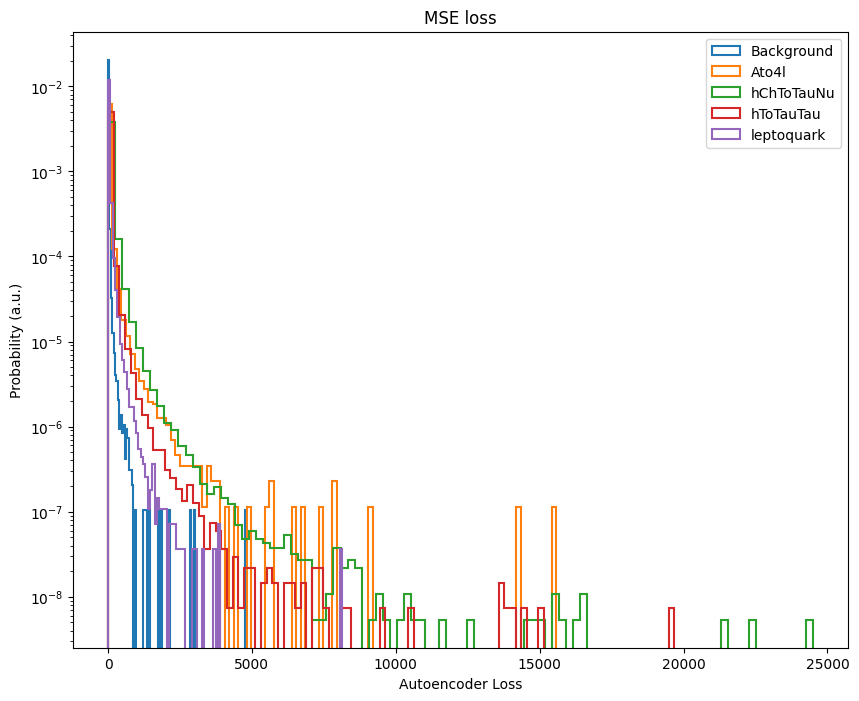

In [30]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

#plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
#plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

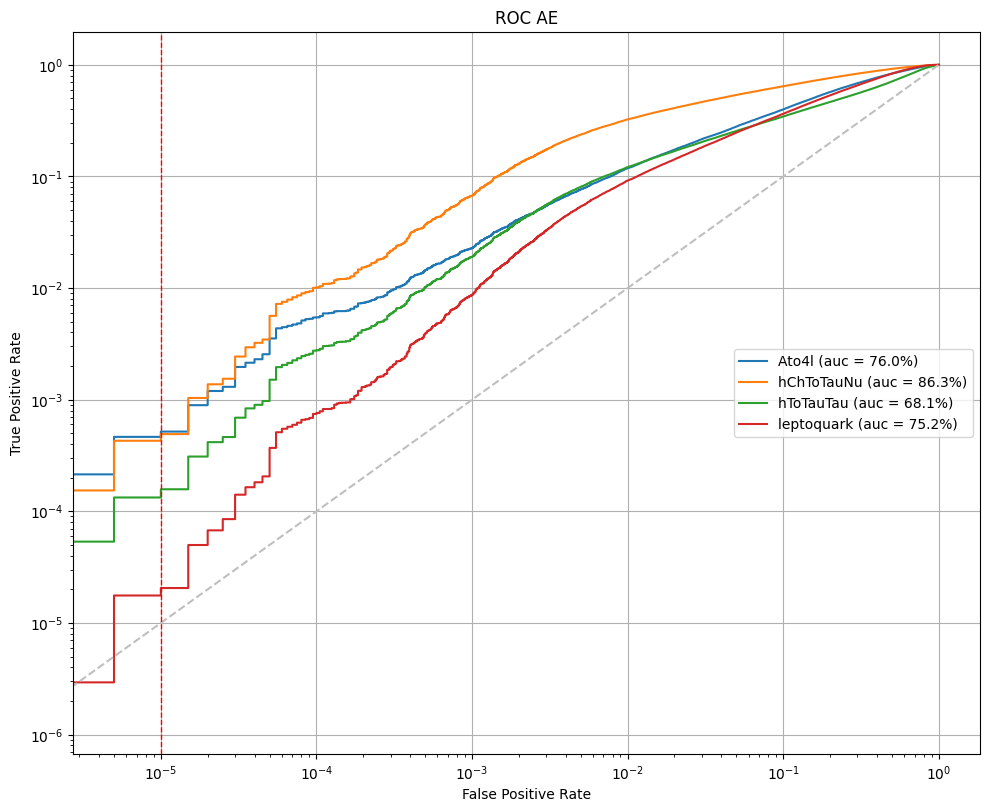

In [31]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

## Evaluation

In [32]:
# Calculate the threshold for a give rejection rate using the background datset

REJECTION_RATE = pow(10, 4)


# Calculate fpr, tpr, thresholds
trueVal = target_background
predVal_loss = np.array(total_loss[0])
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

# Loop over thresholds
for i, thresh in enumerate(threshold_loss):
    preds = (predVal_loss >= thresh)
    rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly

    # Breaking
    if rejection_rate < REJECTION_RATE:
        break

    threshold = thresh # update threshold

pred_test = (predVal_loss >= threshold)
print(f'\nrejection rate = {(len(pred_test) - np.sum(pred_test)) / np.sum(pred_test):.2f}')
print(f'threshold = {threshold:.2f}\n\n')


rejection rate = 10525.32
threshold = 742.97




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-32-ef13861a7d00>:14: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly


In [33]:
from IPython.display import Javascript

<IPython.core.display.Javascript object>


Ato4l:
length of dataset: 55969
TP = 297
TPR = 0.0053



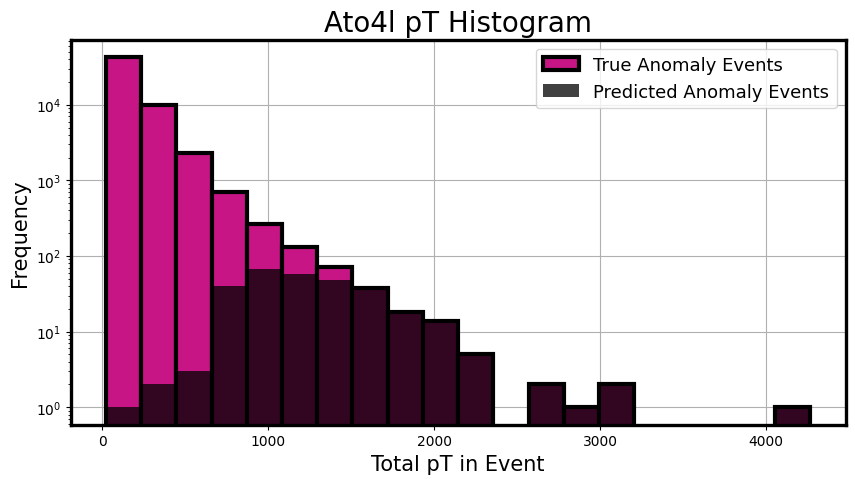

<ipython-input-34-39fa2c672911>:58: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)


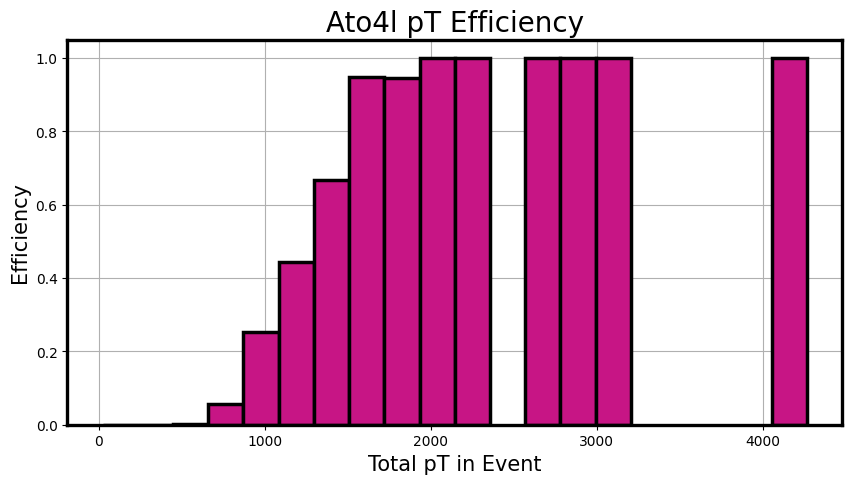

_________________________________________________________________________________________________

hChToTauNu:
length of dataset: 760272
TP = 7122
TPR = 0.0094



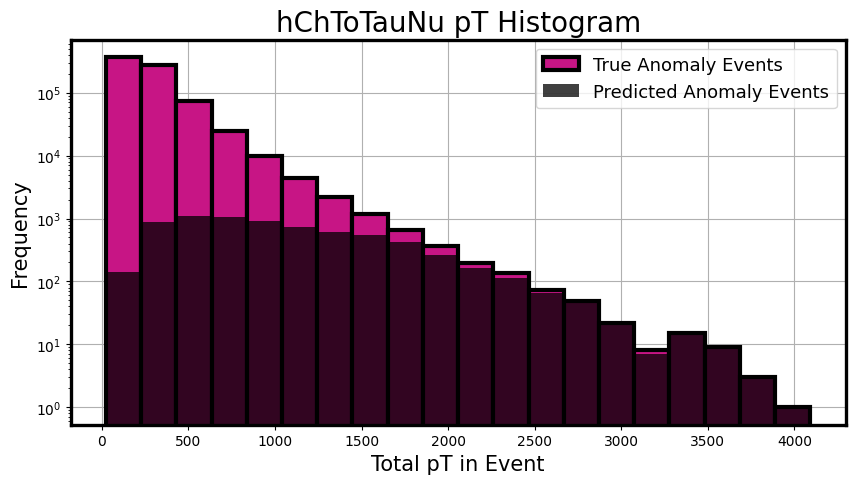

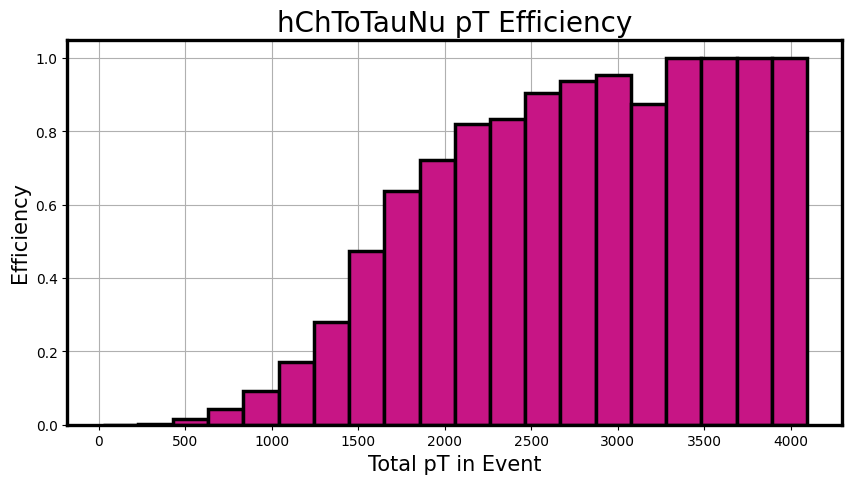

_________________________________________________________________________________________________

hToTauTau:
length of dataset: 691283
TP = 1783
TPR = 0.0026



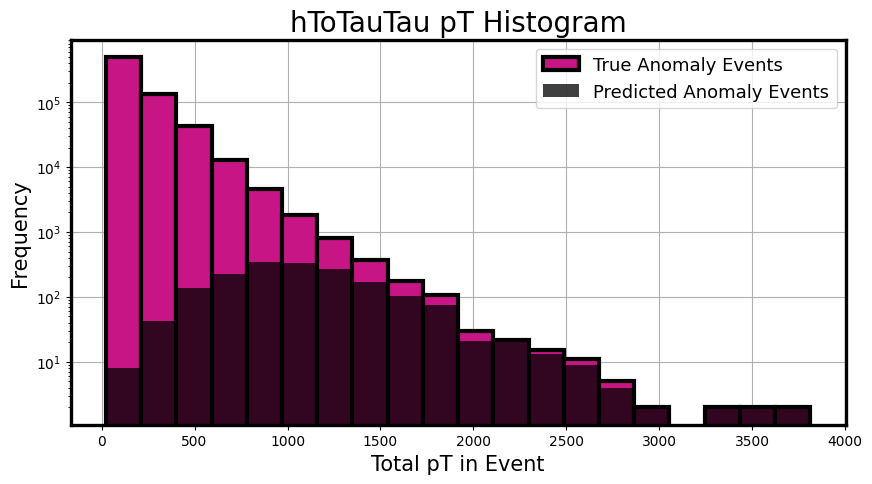

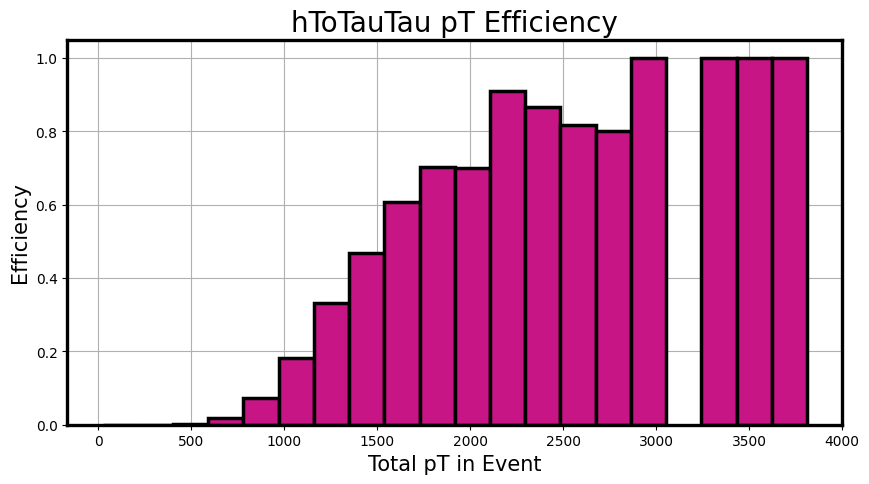

_________________________________________________________________________________________________

leptoquark:
length of dataset: 340544
TP = 234
TPR = 0.0007



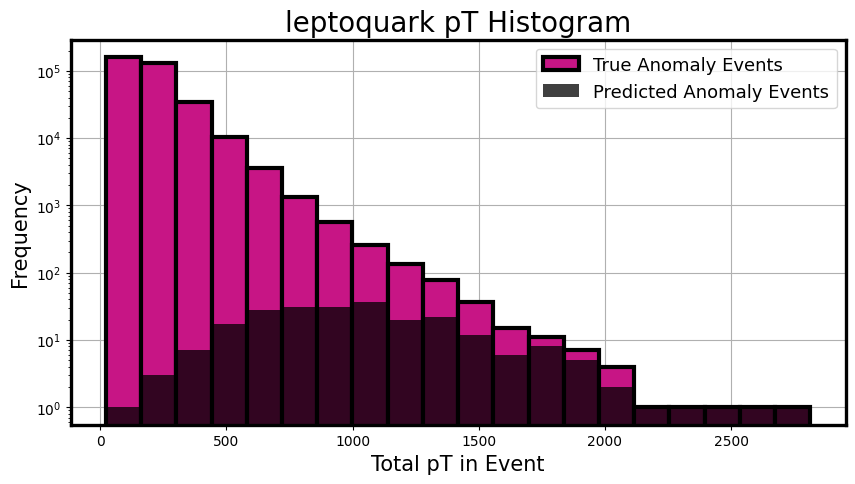

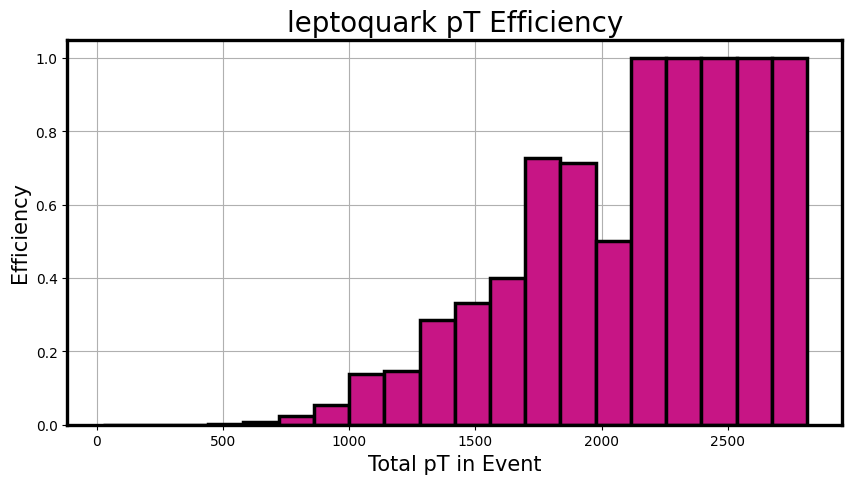

_________________________________________________________________________________________________


In [34]:
# Calcalate the TPR and efficiency of each signal dataset


display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

# Loop over signal datasets
for i, label in enumerate(labels):
    if i ==0: continue # background

    # Calculate TPR
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    true_indices = np.nonzero(trueVal)[0] # true anomaly indices
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= threshold) # 1=anomaly, 0=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction
    correct_pred_indices = np.intersect1d(pred_indices, true_indices)
    TP = len(np.intersect1d(pred_indices, true_indices)) # the number of elements shared between trueVal and predVal
    TPR = TP / np.sum(trueVal)

    # Printing
    print(f'\n{label}:')
    print(f'length of dataset: {total_loss[i].shape[0]}')
    print(f'TP = {TP}')
    print(f'TPR = {TPR:.4f}\n')

    # Get pT from data
    X = np.concatenate((signal_data[i-1], X_test)).reshape(-1, 19, 3, 1) # Data before going through model
    pT = X[:, 1:, 0, 0]
    pT_max = np.max(pT, axis=1) # Maximum pT in each event
    pT_sum = np.sum(pT, axis=1) # Sum of the pT in each event

    # Make histograms
    pT_hist_A, edges_A = np.histogram(pT_sum[true_indices], bins=20) # all events
    pT_hist_B, edges_B = np.histogram(pT_sum[correct_pred_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only events predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)


    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='True Anomaly Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Predicted Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)
    plt.show()
    print('_________________________________________________________________________________________________')